# Filter fragments for synthesizability

## Aim of this notebook

#### This notebook is filtering the fragments for synthesizability.
* The first filter checks the availability of similar buyable building blocks in the [Enamine REAL Space](https://enamine.net/compound-collections/real-compounds/real-space-navigator) to ensure that the resulting molecules can easily be synthesized.
* The second filter calculates the SYnthetic Bayesian Accessibility (SYBA) [(J Cheminform 12, 35 (2020))](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00439-2), which estimates whether a fragment is more likely to be easy or hard to synthesize.

## Table of contents
1. Load fragment library
2. Apply pre-filters
3. Filter for buyable building blocks

    3.1. Data preparation
    
    3.2. Filter fragments for buyable building blocks
4. Filter for SYnthetic Bayesian Accessibility (SYBA)
5. Analyze accepted/rejected fragments

    5.1. Count number of fragments that are accepted by the filter(s)

    5.2. Histogram of SYBA values

## Imports and preprocessing

In [1]:
from pathlib import Path

import pandas as pd
from rdkit.Chem import PandasTools
from IPython.core.display import HTML

from kinfraglib import filters, utils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

### Define global paths

In [4]:
# Path to data
HERE = Path().resolve()
PATH_DATA = HERE / "../../data"
PATH_DATA_ENAMINE = HERE / "../../data/filters/Enamine"

## 1. Load fragment library

Fragment library is stored as a dictionary, with the individual subpockets as keys.

In [5]:
fragment_library_original = utils.read_fragment_library(PATH_DATA / "fragment_library")

In [6]:
fragment_library_original.keys()
# NBVAL_CHECK_OUTPUT

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X'])

In [7]:
pd.concat(fragment_library_original).reset_index(drop=True).shape
# NBVAL_CHECK_OUTPUT

(9505, 15)

## 2. Apply pre-filters
Pre-filters are 
- removing fragments in pool X
- removing duplicates
- removing fragments without dummy atoms (unfragmented ligands)
- removing fragments only connecting to pool X

In [8]:
fragment_library = filters.prefilters.pre_filters(fragment_library_original)

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]"
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 16 7 16 16 16 16 5 16 16 16 16 16 5 5 5 5 5 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]"
2,AP,CC1=C2/C(=N/c3ccccc3)N=CN=[N+]2C=C1,,,,AAK1,NAK,Other,8gmc,YFV,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 16 4 4 4 4...,[39*]c1cccc(/N=C2\N=CN=[N+]3C=CC(C[42*])=C23)c1,1,"[FP, FP]","[AP=FP, AP=FP]"
3,AP,Nc1ncnn2cccc12,,,,AAK1,NAK,Other,8gmd,ZRR,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP GA FP,14 14 14 14 14 14 14 16 14 14 14 14 5 5 na na,*Nc1ncnn2ccc([25*])c12,6,"[GA, FP]","[AP=GA, AP=FP]"
4,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,10,[SE],[AP=SE]

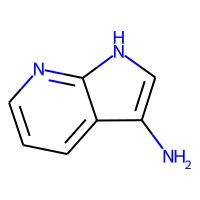
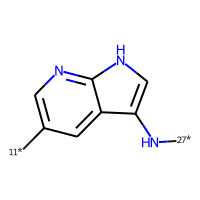
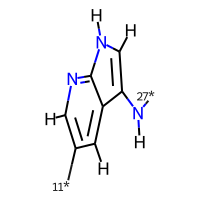
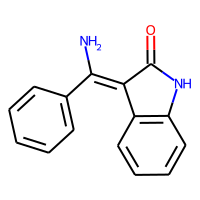
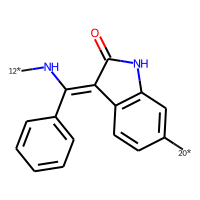
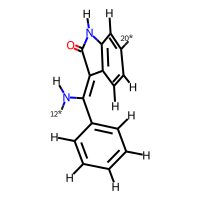
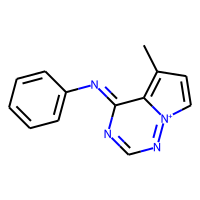
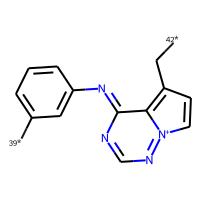
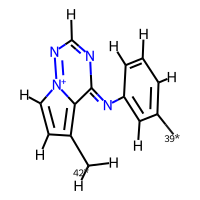
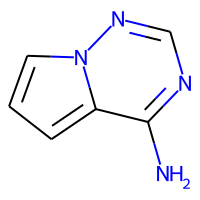
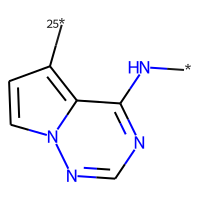
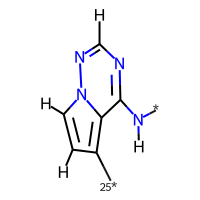
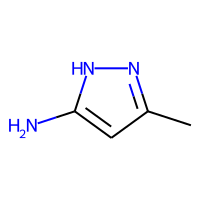
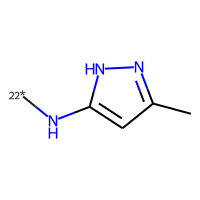
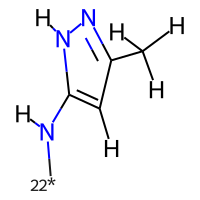

In [9]:
HTML(fragment_library["AP"].head().to_html(notebook=True))
# NBVAL_CHECK_OUTPUT

Count number of fragments in the original fragment library and after pre-filtering the fragment library.

In [10]:
num_fragments = pd.concat(
    [
        filters.analysis.count_fragments(fragment_library_original, "original"),
        filters.analysis.count_fragments(fragment_library, "pre_filtered"),
    ],
    axis=1,
)
num_fragments = pd.concat([num_fragments, num_fragments.sum().rename("Total").to_frame().T])
num_fragments
# NBVAL_CHECK_OUTPUT

,original,pre_filtered
AP,3240,1201
FP,2385,1100
SE,1962,743
GA,1305,355
B1,126,47
B2,113,59
Total,9131,3505


Note: The number of fragments in pool X in the original fragment library is not displayed.

## 3. Filter for buyable building blocks
The [Enamine REAL Space](https://enamine.net/compound-collections/real-compounds/real-space-navigator) contains over 19 billion building blocks that can be used to create compounds which can be synthesized on demand. 

In [11]:
?filters.synthesizability.check_building_blocks

Signature:
filters.synthesizability.check_building_blocks(
    fragment_library,
    path_to_building_blocks,
)
Docstring:
Read in Enamine Building Blocks from SDFile created with filters/enamine_substructures.py
and check if the fragment molecules are a substructure of building block molecules.

Parameters
----------
fragment_library : dict
    fragments organized in subpockets including all information
path_to_building_blocks : str
    path to SDFile with overlapping building blocks is saved

Returns
-------
dict
    Containing a pandas.DataFrame for each subpocket with all fragments and an
    additional columns (bool_bb) defining whether the fragment is accepted (1), meaning found
    as a substructure in a building block, or rejected (0).
File:      ~/KinFragLib/kinfraglib/filters/synthesizability.py
Type:      function

**Note**: A description to the generation of the `data/filters/Enamine/Enamine_Building_Blocks.sdf` file used in this function can be found in the [README](https://github.com/volkamerlab/KinFragLib/blob/master/data/filters/Enamine/README.md) file in the `data/filters/Enamine` directory.

In [12]:
fragment_library = filters.synthesizability.check_building_blocks(
    fragment_library,
    str(str(PATH_DATA_ENAMINE) + "/Enamine_Building_Blocks.sdf"),
)

Number of building blocks: 1562


Inspect individual subpockets, including the new column if similar building block found in ENAMINE (`bool_bb`). 

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,bool_bb
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]",1
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 16 7 16 16 16 16 5 16 16 16 16 16 5 5 5 5 5 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]",0
2,AP,CC1=C2/C(=N/c3ccccc3)N=CN=[N+]2C=C1,,,,AAK1,NAK,Other,8gmc,YFV,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 16 4 4 4 4...,[39*]c1cccc(/N=C2\N=CN=[N+]3C=CC(C[42*])=C23)c1,1,"[FP, FP]","[AP=FP, AP=FP]",0
3,AP,Nc1ncnn2cccc12,,,,AAK1,NAK,Other,8gmd,ZRR,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP GA FP,14 14 14 14 14 14 14 16 14 14 14 14 5 5 na na,*Nc1ncnn2ccc([25*])c12,6,"[GA, FP]","[AP=GA, AP=FP]",1
4,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,10,[SE],[AP=SE],1

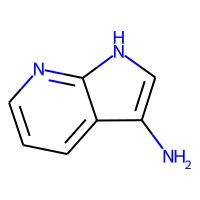
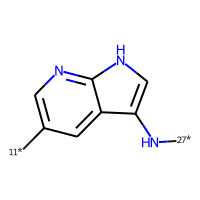
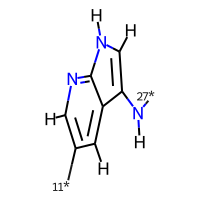
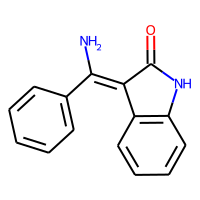
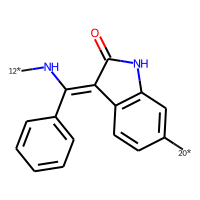
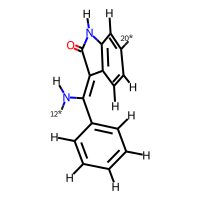
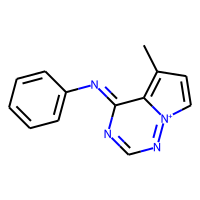
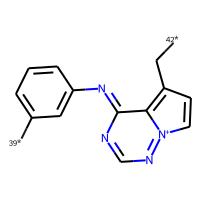
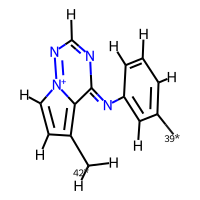
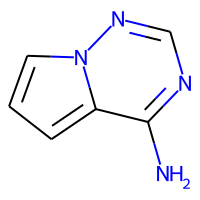
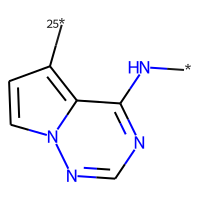
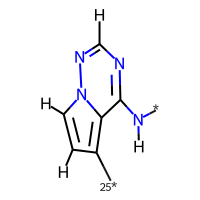
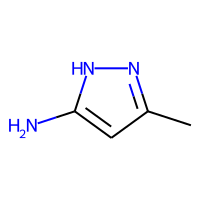
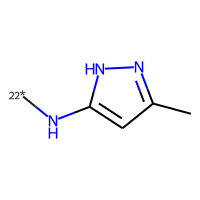
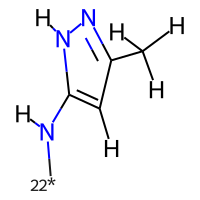

In [13]:
HTML(fragment_library["AP"].head().to_html(notebook=True))
# NBVAL_CHECK_OUTPUT

Count number of pre-filtered fragments and number of fragments that are accepted and rejected by the Building Block filter.

In [14]:
num_fragments_bb = pd.concat(
    [
        filters.analysis.count_fragments(fragment_library, "pre_filtered"),
        filters.analysis.count_accepted_rejected(
            fragment_library, "bool_bb", "enamine"
        ),
    ],
    axis=1,
)
num_fragments_bb = pd.concat([num_fragments_bb, num_fragments_bb.sum().rename("Total").to_frame().T])
num_fragments_bb
# NBVAL_CHECK_OUTPUT

,pre_filtered,accepted_enamine,rejected_enamine
AP,1201,520,681
FP,1100,527,573
SE,743,399,344
GA,355,286,69
B1,47,42,5
B2,59,46,13
Total,3505,1820,1685


## 4. Filter for SYnthetic Bayesian Accessibility (SYBA)

The SYnthtetic Bayesian Accessibility Score (SYBA) [(J Cheminform 12, 35 (2020))](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00439-2) is a Bayesian probabilistic modeling method ([SYBA github repo](https://github.com/lich-uct/syba)) for calculating a fragment-based score using the frequency of fragments in easy- and hard-to-synthesizable molecules. 

A more negative score indicates a molecule which is more likely hard to synthesize, and a more positive score indicates a molecule which is more likely easy to synthesize.

In [15]:
?filters.synthesizability.calc_syba

Signature:
filters.synthesizability.calc_syba(
    fragment_library,
    cutoff=0,
    cutoff_criteria='>',
    query_type='mol',
)
Docstring:
Calculate the SYnthetic Bayesian Accessibility (SYBA) for each fragment and add a boolean
column if the fragment is accepted for the defined cutoff or not and a column with the
calculated SYBA values.

Parameters
----------
fragment_library : dict
    fragments organized in subpockets including all information
cutoff : int
    defining the cutoff value for rejecting/accepting fragments. By , cutoff=0
cutoff_criteria : str
    defining if the fragment values need to be ">", "<", ">=", "<=", "==" or "!=" compared to
    the cutoff_value. By default, cutoff_criteria=">"
query_type : str
    "mol" or "smiles". Defining if the SYBA score gets predicted using the ROMol from the
    fragment library or the SMILES string. By default, query_type = "mol".

Returns
dict
    Containing a pandas.DataFrame for each subpocket with all fragments and an
    addi

In [16]:
fragment_library = filters.synthesizability.calc_syba(fragment_library, cutoff=0)

Inspect individual subpockets, including the new column if SYBA score threshold fulfilled (`bool_syba`) and calculated SYBA score (`syba`). 

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,bool_bb,bool_syba,syba
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]",1,1,30.950959
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 16 7 16 16 16 16 5 16 16 16 16 16 5 5 5 5 5 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]",0,1,17.682659
2,AP,CC1=C2/C(=N/c3ccccc3)N=CN=[N+]2C=C1,,,,AAK1,NAK,Other,8gmc,YFV,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 16 4 4 4 4...,[39*]c1cccc(/N=C2\N=CN=[N+]3C=CC(C[42*])=C23)c1,1,"[FP, FP]","[AP=FP, AP=FP]",0,1,0.611823
3,AP,Nc1ncnn2cccc12,,,,AAK1,NAK,Other,8gmd,ZRR,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP GA FP,14 14 14 14 14 14 14 16 14 14 14 14 5 5 na na,*Nc1ncnn2ccc([25*])c12,6,"[GA, FP]","[AP=GA, AP=FP]",1,1,28.754427
4,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,10,[SE],[AP=SE],1,1,15.727015

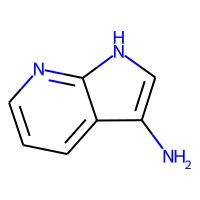
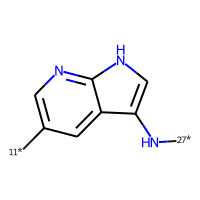
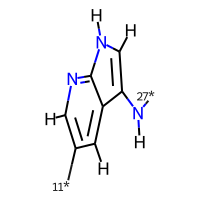
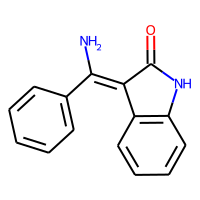
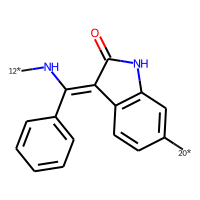
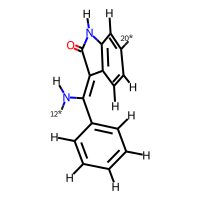
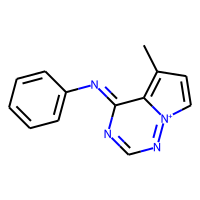
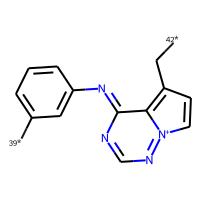
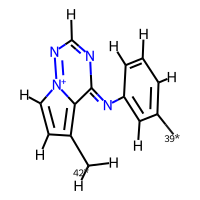
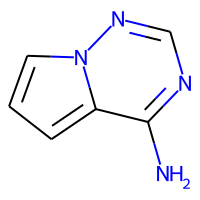
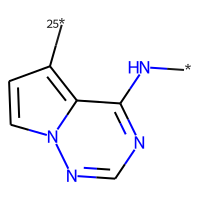
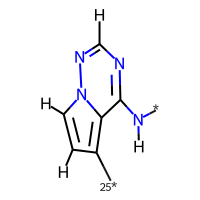
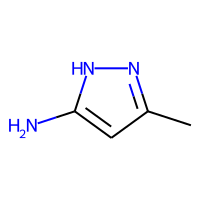
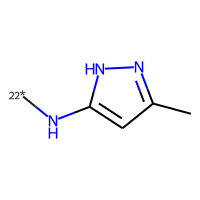
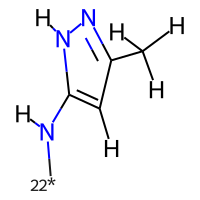

In [17]:
HTML(fragment_library["AP"].head().to_html(notebook=True))
# NBVAL_CHECK_OUTPUT

Count number of pre-filtered fragments and number of fragments that are accepted and rejected by the SYBA filter.

In [18]:
num_fragments_syba = pd.concat(
    [
        filters.analysis.count_fragments(
            fragment_library, "pre_filtered"
        ),
        filters.analysis.count_accepted_rejected(
            fragment_library, "bool_syba", "syba"
        ),
    ],
    axis=1,
)
num_fragments_syba = pd.concat([num_fragments_syba, num_fragments_syba.sum().rename("Total").to_frame().T])
num_fragments_syba
# NBVAL_CHECK_OUTPUT

,pre_filtered,accepted_syba,rejected_syba
AP,1201,1070,131
FP,1100,858,242
SE,743,664,79
GA,355,328,27
B1,47,37,10
B2,59,53,6
Total,3505,3010,495


## 5. Analyze accepted/rejected fragments

    5.1. Count number of fragments that are accepted by the filter(s)

    5.2. Histogram of SYBA values

### 5.1. Count number of fragments that are accepted by the filter(s)

In [19]:
fragment_library = filters.analysis.number_of_accepted(
    fragment_library, columns=["bool_syba", "bool_bb"], min_accepted=2
)

In [20]:
filters.analysis.accepted_num_filters(
    fragment_library,
    ["bool_syba", "bool_bb"],
    filtername="synthesizability filters",
    max_num_accepted=2,
)

,pre-filtered,accepted by 2,accepted by 1,accepted by 0
AP,1201,505,580,116
FP,1100,426,533,141
SE,743,354,355,34
GA,355,267,80,8
B1,47,34,11,2
B2,59,40,19,0
Total,3505,1626,1578,301


### 5.2. Histogram of SYBA values
Create a histogram for each subpocket showing the SYBA values.

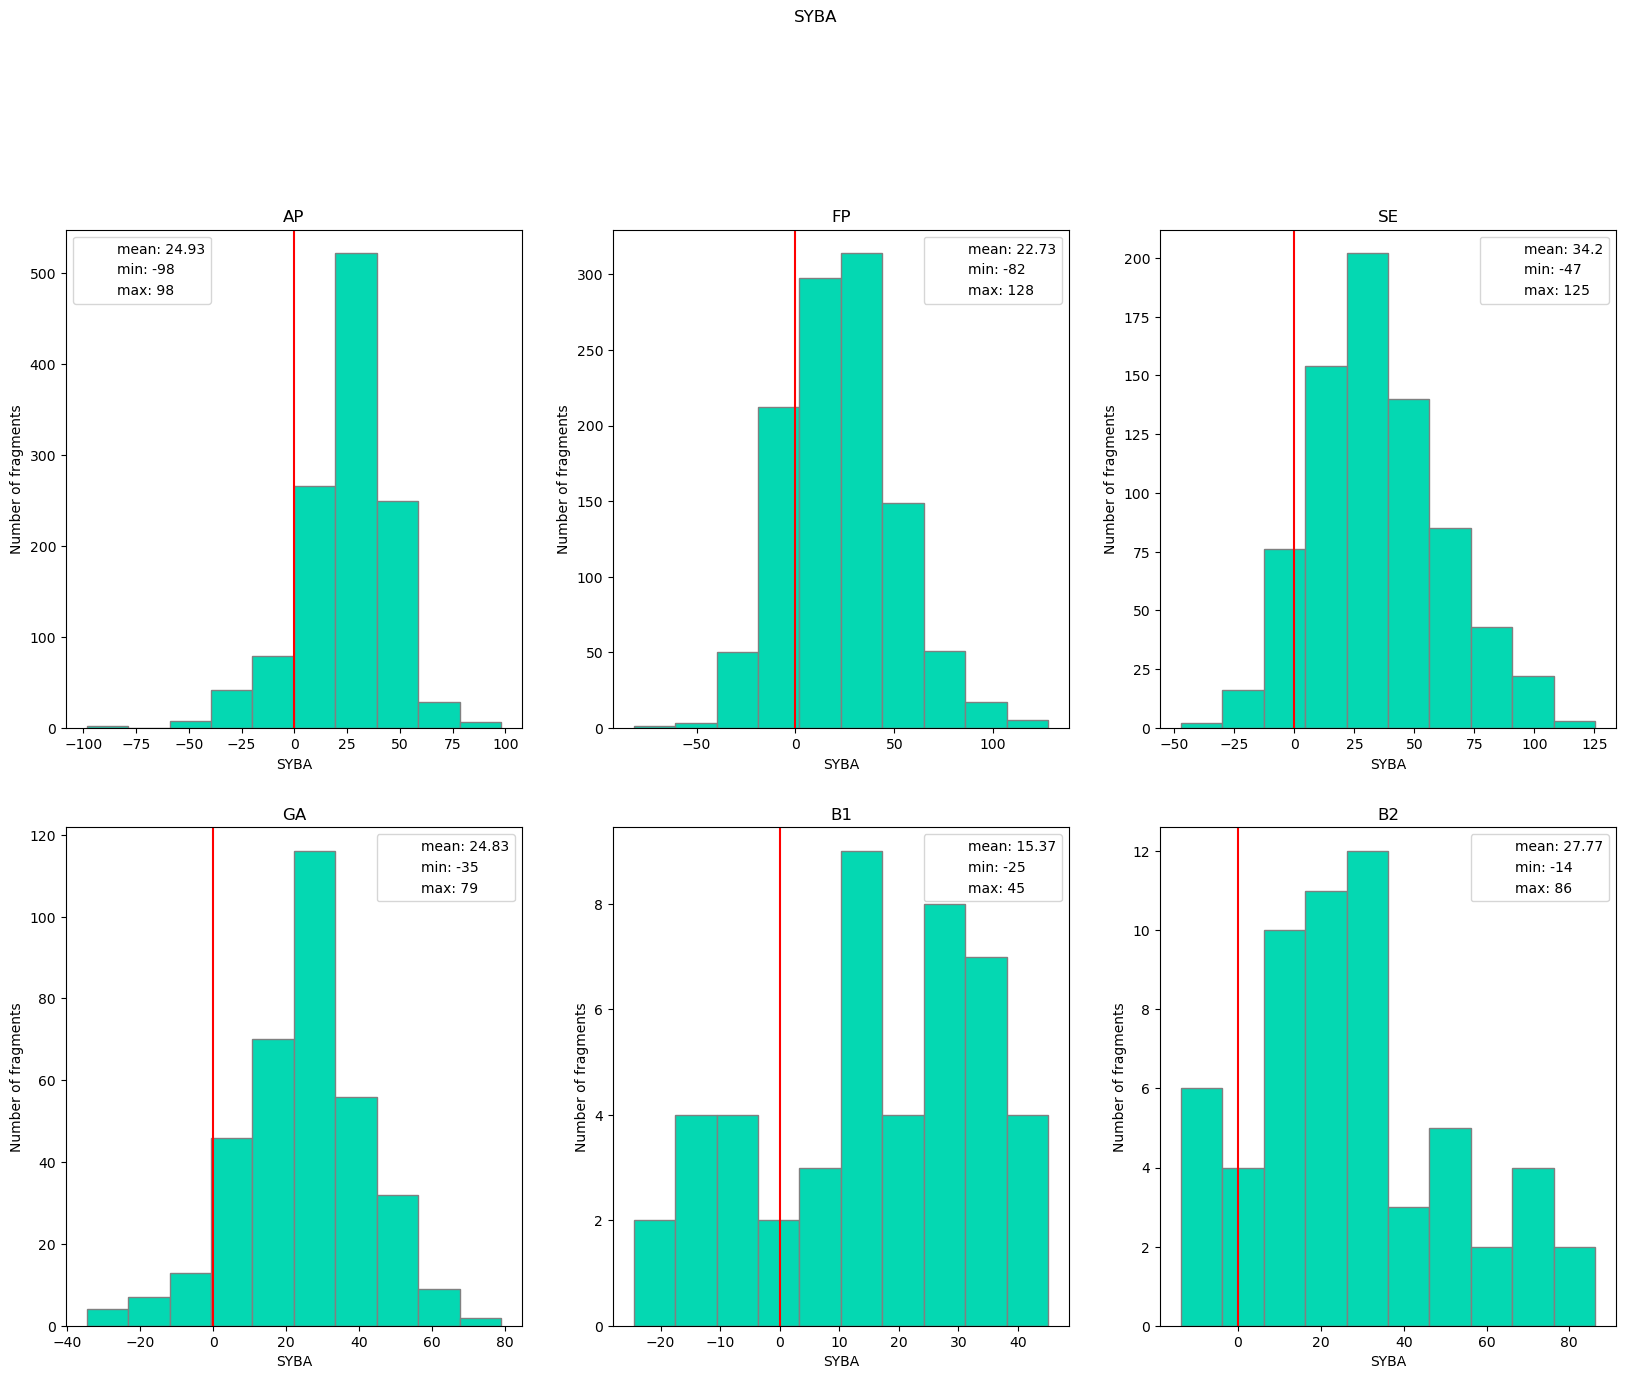

In [21]:
filters.plots.make_hists(
   fragment_library, colname="syba", filtername="SYBA", plot_stats=True, cutoff=0
)